In [ ]:
import pandas as pd
import sys
sys.path.append('../')
from source.pacmap_functions import *

mount = '/mnt/d/'
input_path = mount + 'MethylScore/Intermediate_Files/'
output_path = mount + 'MethylScore/Processed_Data/'

# read df_discovery and df_test
discovery_data = pd.read_pickle(
    input_path+'3308samples_333059cpgs_withbatchcorrection_bvalues.pkl').sort_index()

validation_data = pd.read_pickle(
    input_path+'201samples_357839cpgs_withbatchcorrection_bvalues.pkl').sort_index()

# Load clinical data
discovery_meta = pd.read_csv(input_path+'discovery_clinical_data.csv',
                                      low_memory=False, index_col=0)

# Load clinical data
validation_meta = pd.read_csv(input_path+'validation_clinical_data.csv',
                                        low_memory=False, index_col=0)

In [ ]:
# use overlapping features between discovery_data and validation_data
common_features = [x for x in discovery_data.columns if x in validation_data.columns]

# apply `common_features` to both discovery_data and validation_data
discovery_data = discovery_data[common_features]
validation_data = validation_data[common_features]

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# import pacmap


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        
        self.input_dim = input_dim  # Store input_dim as an instance variable

        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)  # mean
        self.fc22 = nn.Linear(hidden_dim, latent_dim)  # log variance

        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
        
        self.sigmoid = nn.Sigmoid()


    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_dim))  # Use the instance variable here
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar, input_dim):  # Add input_dim as a parameter
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, input_dim), reduction='sum')  # Use it here
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    total_loss = BCE + KLD
    return total_loss, BCE

In [ ]:
# # What is this doing on the data?
# discovery_meta['Batch'] = discovery_data['Batch']
# discovery_data.drop(columns=['Batch'], inplace=True)

# Convert DataFrames to tensors
discovery_data_scaled = scaler.fit_transform(discovery_data)
discovery_tensor = torch.tensor(discovery_data_scaled, dtype=torch.float32)

validation_data_scaled = scaler.fit_transform(validation_data)
validation_tensor = torch.tensor(validation_data_scaled, dtype=torch.float32)

batch_size = 32

# DataLoader
train_loader = DataLoader(discovery_tensor, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_tensor, batch_size=batch_size, shuffle=False)

In [ ]:
# Reduced dimensions
smaller_hidden_dim = 100
smaller_latent_dim = 2
num_epochs = 100

vae_model = VAE(input_dim=discovery_data.shape[1], hidden_dim=smaller_hidden_dim, latent_dim=smaller_latent_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae_model.to(device) 
optimizer = torch.optim.Adam(vae_model.parameters(), lr=0.0001, weight_decay=1e-5)  # Example of defining an optimizer

for epoch in range(num_epochs):
    train_loss = 0
    reconstruction_error = 0

    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)  # Move the data to the device
        optimizer.zero_grad()

        recon_batch, mu, logvar = vae_model(data)
        # print("Output range: min =", recon_batch.min().item(), "max =", recon_batch.max().item())  # Check output range

        # Ensure data is correctly reshaped to match recon_batch
        data_reshaped = data.view(-1, discovery_data.shape[1])
        # print("Data shape:", data_reshaped.shape, "Reconstructed shape:", recon_batch.shape)  # Check shapes

        loss, bce = loss_function(recon_batch, data_reshaped, mu, logvar, input_dim=discovery_data.shape[1])
        loss.backward()

        train_loss += loss.item()
        reconstruction_error += bce.item()

        print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item()}, Reconstruction Error: {bce.item()}')

        optimizer.step()

    train_loss /= len(train_loader.dataset)
    reconstruction_error /= len(train_loader.dataset)

    print(f'Epoch: {epoch}, Loss: {train_loss}, Reconstruction Error: {reconstruction_error}')


# Save the model
torch.save(vae_model.state_dict(), 'vae.pth')

vae_model.eval()

with torch.no_grad():
    for batch_idx, data in enumerate(validation_loader):
        data = data.to(device)
        recon_batch, mu, logvar = vae_model(data)  # Unpack mu and logvar along with recon_batch
        loss, bce = loss_function(recon_batch, data, mu, logvar, input_dim=validation_data.shape[1])
        print(f'Loss: {loss.item()}, Reconstruction Error: {bce.item()}')


# Test the model
# vae_model.eval()

# with torch.no_grad():
#     for batch_idx, (indices, data) in enumerate(validation_loader):
#         data = data.to(device)
#         recon_batch, mu = vae_model(data)
#         loss, bce = loss_function(recon_batch, data, mu, logvar, input_dim=validation_data.shape[1])
#         print(f'Loss: {loss.item()}, Reconstruction Error: {bce.item()}')

Epoch: 0, Batch: 0, Loss: 7207697.0, Reconstruction Error: 7207696.5
Epoch: 0, Batch: 1, Loss: 12976902.0, Reconstruction Error: 12972754.0
Epoch: 0, Batch: 2, Loss: 7597605.0, Reconstruction Error: 7596789.5
Epoch: 0, Batch: 3, Loss: 9897749.0, Reconstruction Error: 9895547.0
Epoch: 0, Batch: 4, Loss: 8349457.0, Reconstruction Error: 8348079.5
Epoch: 0, Batch: 5, Loss: 7278586.0, Reconstruction Error: 7277728.5
Epoch: 0, Batch: 6, Loss: 8242294.0, Reconstruction Error: 8240891.0
Epoch: 0, Batch: 7, Loss: 8101960.5, Reconstruction Error: 8100600.0
Epoch: 0, Batch: 8, Loss: 7248547.0, Reconstruction Error: 7247618.0
Epoch: 0, Batch: 9, Loss: 7331440.5, Reconstruction Error: 7330420.0
Epoch: 0, Batch: 10, Loss: 7649953.5, Reconstruction Error: 7648726.5
Epoch: 0, Batch: 11, Loss: 7523443.0, Reconstruction Error: 7522279.5
Epoch: 0, Batch: 12, Loss: 7157719.5, Reconstruction Error: 7156722.0
Epoch: 0, Batch: 13, Loss: 7123875.0, Reconstruction Error: 7122909.0
Epoch: 0, Batch: 14, Loss: 7

In [ ]:
vae_model.eval()  # Set the model to evaluation mode

# Ensure model is on the correct device (e.g., GPU if you're using one)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae_model = vae_model.to(device)

# Get new dataset
with torch.no_grad():
    # Convert discovery_data to a PyTorch tensor and move it to the same device as the model
    data_tensor = torch.tensor(discovery_data.values, dtype=torch.float32).to(device)
    
    # Pass data through the encoder of the model instance
    mu, _ = vae_model.encode(data_tensor)
    
    # Convert the latent space features back to a pandas DataFrame
    latent_features = mu.cpu().numpy()  # Move the tensor back to CPU for numpy conversion
    latent_df = pd.DataFrame(latent_features, index=discovery_data.index)

# Assuming 'latent_df' is your latent space DataFrame
# Convert it to numpy array if it's a DataFrame
latent_space_data = latent_df.to_numpy()


In [ ]:
latent_space_data

array([[-2.425089 , 14.132718 ],
       [ 5.24748  ,  8.683295 ],
       [ 3.1437628, 11.903647 ],
       ...,
       [ 4.643728 ,  8.660627 ],
       [ 4.8669105, 10.274462 ],
       [ 6.177587 ,  8.271479 ]], dtype=float32)

In [1]:
# import pacmap
# # Apply PaCMAP
# embedding = pacmap.PaCMAP(n_components=2, n_neighbors=15, MN_ratio=0.4, FP_ratio=16.0, 
#                                 random_state=42, lr=0.1, num_iters=5000)  # or n_components=3 for 3D
# X_transformed = embedding.fit_transform(latent_space_data)

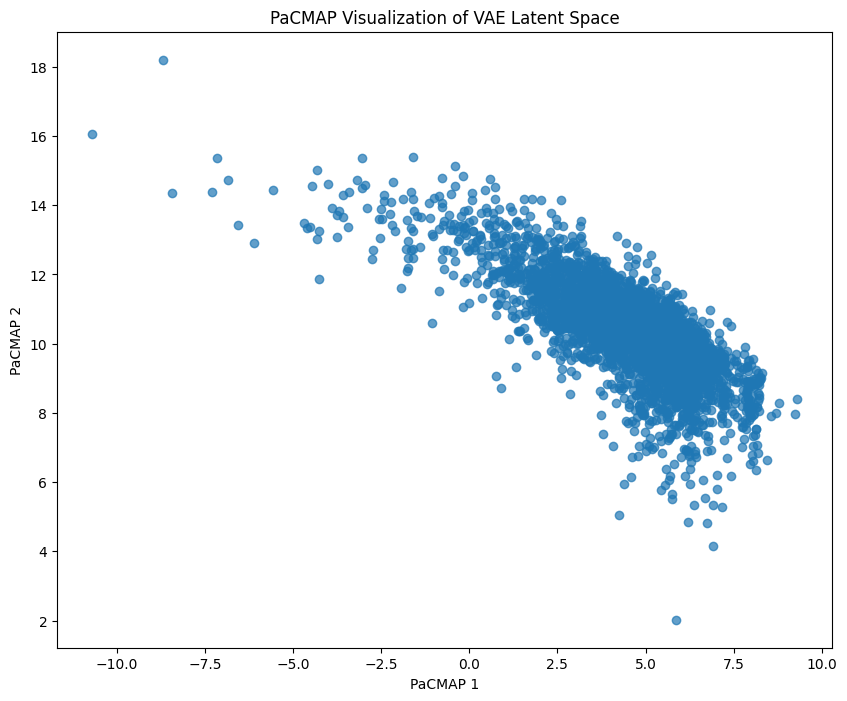

In [ ]:
# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(latent_space_data[:, 0], latent_space_data[:, 1], alpha=0.7)
plt.xlabel('PaCMAP 1')
plt.ylabel('PaCMAP 2')
plt.title('PaCMAP Visualization of VAE Latent Space')
plt.show()